# EIS test measurments

### Importing

In [68]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from importlib import reload
import pandas as pd
from scipy.fft import fft, fftfreq
import os
import numpy as np
import nidaqmx
from nidaqmx.constants import TerminalConfiguration, AcquisitionType
import matplotlib.pyplot as plt
import time


import src.Keysight_DAQ360A_pyvisa
import src.SDG_pyvisa

reload(src.Keysight_DAQ360A_pyvisa)
reload(src.SDG_pyvisa)

from src.Keysight_DAQ360A_pyvisa import Keysight_DAQ370A
from src.SDG_pyvisa import SDG

### Functions

In [69]:
def generate_sine_wave(
    frequency: float,
    amplitude: float,
    sampling_rate: float,
    number_of_samples: int,
    phase_in: float = 0.0,
):
    """Generates a sine wave with a specified phase.

    Args:
        frequency: Specifies the frequency of the sine wave.
        amplitude: Specifies the amplitude of the sine wave.
        sampling_rate: Specifies the sampling rate of the sine wave.
        number_of_samples: Specifies the number of samples to generate.
        phase_in: Specifies the phase of the sine wave in radians.

    Returns:
        Indicates a tuple containing the generated data and the phase
        of the sine wave after generation.
    """
    duration_time = number_of_samples / sampling_rate
    duration_radians = duration_time * 2 * np.pi
    phase_out = (phase_in + duration_radians) % (2 * np.pi)
    t = np.linspace(phase_in, phase_in + duration_radians, number_of_samples, endpoint=False)

    return (amplitude * np.sin(frequency * t), phase_out)

def fft_sine(t, y):
    N = len(t)
    dt = t[1] - t[0]
    freq = fftfreq(N, dt)
    Y = fft(y.values-np.mean(y.values))
    
    # Consider only positive frequencies
    positive_idx = np.where(freq > 0)
    Y_positive = Y[positive_idx]
    freq_positive = freq[positive_idx]
    
    # Find the dominant frequency component
    idx = np.argmax(np.abs(Y_positive))
    f_est = freq_positive[idx]
    A_est = (2 * np.abs(Y_positive[idx])) / N
    phi_est = np.angle(Y_positive[idx])
    C_est = np.mean(y)
    phase_deg = (phi_est / (2 * np.pi)) * 360 % 360
    
    # Add ALIGNED flag if desired (for example, checking if phase is within a tolerance)
    # Here we use a dummy condition; modify as needed for your application.
    aligned = "YES" if abs(phase_deg - 45) < 10 else "NO"
    
    result = pd.Series({
        'Amplitude': A_est,
        'Frequency': f_est,
        'Phase': phase_deg,
        'Offset': C_est,
        'ALIGNED': aligned
    })
    
    return result

def create_df_with_prefix(series1, series2, prefix1, prefix2):
    """
    Combine two Series with prefixes into one row DataFrame
    """
    # Rename series with prefix
    series1 = series1.add_prefix(f"{prefix1}_")
    series2 = series2.add_prefix(f"{prefix2}_")

    # Merge both series into one row DataFrame
    return pd.concat([series1, series2]).to_frame().T

def import_csv_folder(folder_path):
    csv_dict = {}
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            name = os.path.splitext(filename)[0]
            csv_dict[name] = pd.read_csv(os.path.join(folder_path, filename))
    return csv_dict

def plot_frequency_subplots(freq_dict):
    num_freqs = len(freq_dict)
    fig, axs = plt.subplots(num_freqs, 1, figsize=(12, 4 * num_freqs), sharex=False)
    
    if num_freqs == 1:
        axs = [axs]  # Make sure axs is iterable if only one frequency
    
    for i, (freq, df) in enumerate(freq_dict.items()):
        ax1 = axs[i]
        ax2 = ax1.twinx()
        
        # Plot Voltage over Time (left axis)
        ax1.plot(df['Time'], df['Voltage'], color='b', label=f'Voltage @ {freq} Hz')
        ax1.set_ylabel('Voltage (V)')
        ax1.set_title(f'Voltage and Current over Time @ {freq} Hz')
        ax1.grid(True)
        ax1.legend(loc='upper left')
        
        # Plot Current over Time (right axis)
        ax2.plot(df['Time'], df['Current'], color='r', label=f'Current @ {freq} Hz')
        ax2.set_ylabel('Current (A)')
        ax2.legend(loc='upper right')
        
        ax1.set_xlabel('Time (s)')

    plt.tight_layout()
    plt.show()

def plot_nyquist(ax, data, label, title):

    ax.plot(data.Impedance_real*1000, data.Impedance_imag*1000, '.-', label=label)
    plot_preferences(ax, xlabel = 'Re [mOhm]', ylabel = 'Im [mOhm]', title = title, legend=True)

def plot_bode_re_imag(ax,data, label, title):

    ax[0].plot(data.Frequency, data.Impedance_real*1000, '.-', label=label)
    ax[1].plot(data.Frequency, data.Impedance_imag*1000,'.-', label=label) 
    ax[2].plot(data.Frequency, data.Impedance_imag/(2*np.pi*data.Frequency)*1000000000, '.-', label=label) 

    plot_preferences(ax[0], xlabel = '', ylabel = 'Real [mOhm]', title=title, legend=True)
    plot_preferences(ax[1], xlabel = '', ylabel = 'Imag [mOhm]', legend=True)
    plot_preferences(ax[2], xlabel = 'Frequency [Hz]', ylabel = 'Inductance [nH]', legend=True)

def plot_bode(ax,data, label, title):

    ax[0].plot(data.Frequency, data.Impedance_real*1000, '.-', label=label)
    ax[1].plot(data.Frequency, data.Impedance_imag*1000,'.-', label=label) 

    plot_preferences(ax[0], xlabel = '', ylabel = 'Amplitude [mOhm]', title=title, legend=False)
    plot_preferences(ax[1], xlabel = '', ylabel = 'Phase [deg]', legend=False)

def plot_preferences(axs, xlabel = '', ylabel = '', title = '', legend = False):
        
        axs.set_xlabel(xlabel)
        axs.set_ylabel(ylabel)
        if legend: axs.legend()
        axs.grid()

        axs.set_title(title, fontweight="bold")

        axs.minorticks_on()
        axs.grid(which='minor', linewidth = 0.5, linestyle='dotted')
        axs.grid(which='major', linewidth = 0.5, linestyle='-')

### Constatns

In [70]:
impedance_name = '2mOhm_gen2_PowerCo_5'
folder = 'Impedance_data_gen2_powerCo_fixture'

### Performing measurments

In [71]:
config_df =pd.read_excel('config_cal.xlsx')
meas_data_dict = {}
shunt_value = 0.008

for config in config_df.itertuples(index=True):
    
    # Define AO and AI tasks
    with nidaqmx.Task() as ai_task, nidaqmx.Task() as ao_task:

        # Analog Input configuration (2 channels, differential)

        # Current measruemt channel
        ai_task.ai_channels.add_ai_voltage_chan(
            physical_channel = "Dev1/ai0",
            terminal_config=TerminalConfiguration.DIFF,
            min_val=-config.Ch0_range, max_val=config.Ch0_range
        )
        # Voltage measruemt channel
        ai_task.ai_channels.add_ai_voltage_chan(
            physical_channel = "Dev1/ai1",
            terminal_config=TerminalConfiguration.DIFF,
            min_val=-config.Ch1_range, max_val=config.Ch1_range
        )
        ai_task.timing.cfg_samp_clk_timing(
            rate=config.Samp_rate_input,
            sample_mode=AcquisitionType.FINITE,
            samps_per_chan=config.Samp_count
        )
        actual_sampling_rate_input = ai_task.timing.samp_clk_rate

        # Analog Output configuration
        ao_task.ao_channels.add_ao_voltage_chan(
            physical_channel="Dev1/ao0",
            min_val=-2, max_val=2
        )
        ao_task.timing.cfg_samp_clk_timing(
            samps_per_chan=config.Samp_count,
            rate=config.Samp_rate_output,
            sample_mode=AcquisitionType.CONTINUOUS,
        )
        actual_sampling_rate_output = ao_task.timing.samp_clk_rate
        sine_wave, _ = generate_sine_wave(
                frequency=config.Frequency,
                amplitude=config.Current_rms*np.sqrt(2)/100,
                sampling_rate=actual_sampling_rate_output,
                number_of_samples= int(actual_sampling_rate_output*(config.Samp_count/actual_sampling_rate_input * 2 + config.Stabil_time)),
            )
        ao_task.write(sine_wave, auto_start=False)

        # Start both tasks 
        ao_task.start()
        time.sleep(config.Stabil_time)
        ai_task.start()
        ai_task.wait_until_done(timeout=10.0)
        ao_task.stop()

    
        data = ai_task.read(number_of_samples_per_channel=config.Samp_count)
        t_input = np.linspace(0, config.Samp_count/actual_sampling_rate_input, config.Samp_count, endpoint=False)

        meas_data = pd.DataFrame({
                    'Current': np.array(data[0]),
                    'Voltage': np.array(data[1]),            
                    'Time': t_input
                    })
    
    meas_data_dict[config.Frequency] = meas_data

### Sine FFT

In [56]:
all_results = []

for frequency in meas_data_dict:
    meas_data = meas_data_dict[frequency]

    current_result = fft_sine(meas_data.Time, meas_data.Current)
    voltage_result = fft_sine(meas_data.Time, meas_data.Voltage)

    df_row = create_df_with_prefix(current_result, voltage_result, prefix1="Current", prefix2="Voltage")
    df_row["Frequency"] = frequency
    all_results.append(df_row)

# Final DataFrame
impedance_df = pd.concat(all_results, ignore_index=True)  

### Plotting comparison

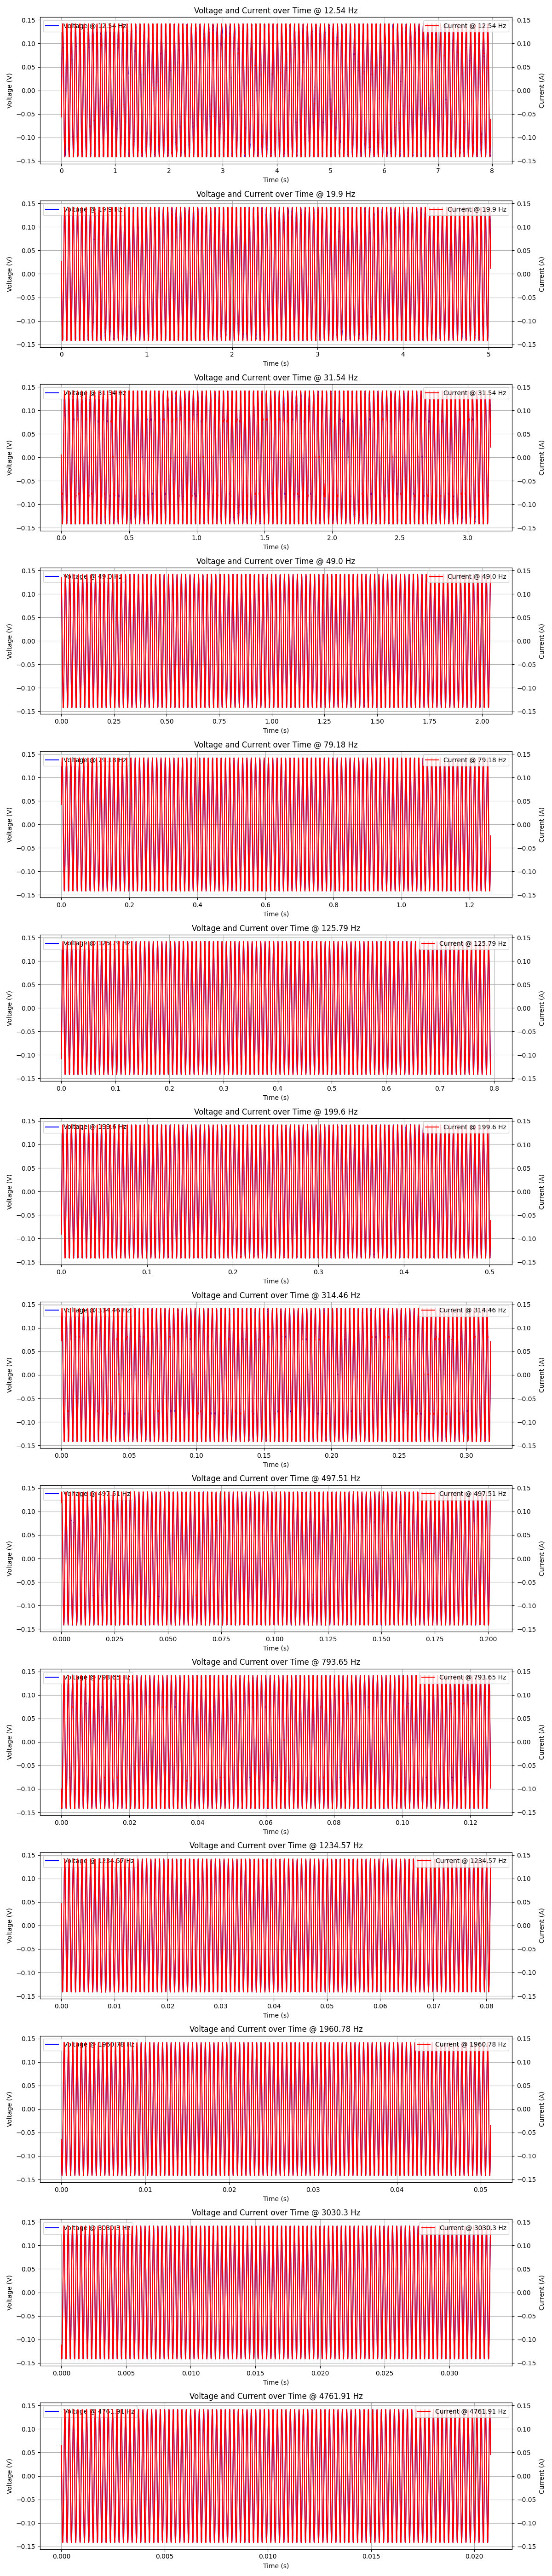

In [72]:
%matplotlib widget
plot_frequency_subplots(meas_data_dict)


### Caluclating impednace

In [58]:
from math import cos, sin
impedance_df['Impedance_amplitude'] = impedance_df.Voltage_Amplitude/impedance_df.Current_Amplitude
impedance_df['Impedance_phase'] = impedance_df.Voltage_Phase-impedance_df.Current_Phase

impedance_df['Impedance_phase'] = pd.to_numeric(impedance_df['Impedance_phase'])
impedance_df['Impedance_real'] = impedance_df.Impedance_amplitude * np.cos(impedance_df.Impedance_phase*np.pi/180)
impedance_df['Impedance_imag'] = impedance_df.Impedance_amplitude * np.sin(impedance_df.Impedance_phase*np.pi/180)

In [60]:
impedance_df

Current_Amplitude Current_Frequency Current_Phase Current_Offset  \
0           0.014148         12.540757    122.983949      -0.000088   
1           0.014141         19.896538     96.388161      -0.000088   
2            0.01414         31.545741    196.264211      -0.000086   
3           0.014112         49.019608    317.680746      -0.000091   
4           0.014021         79.239303    234.916542      -0.000082   
5           0.013809        125.944584      277.3684       -0.00009   
6           0.014112        199.521149    305.684325      -0.000069   
7           0.014148        314.465409    157.341741      -0.000106   
8           0.013932        497.017893      6.836409      -0.000051   
9           0.014145        793.650794     55.073482       -0.00008   
10          0.012786       1237.623762    292.763925      -0.000071   
11          0.010854          1953.125      8.115552      -0.000024   
12          0.010789       3042.168675    342.910711      -0.000128   
13          0.013929       4759.615385    263.663043      -0.000083   

   Current_ALIGNED Voltage_Amplitude Voltage_Frequency Voltage_Phase  \
0               NO          0.014148         12.540757    122.983984   
1               NO          0.014141         19.896538     96.387924   
2               NO           0.01414         31.545741    196.264154   
3               NO          0.014112         49.019608    317.680988   
4               NO          0.014021         79.239303    234.916932   
5               NO          0.013809        125.944584    277.367225   
6               NO          0.014113        199.521149    305.683846   
7               NO          0.014148        314.465409    157.342748   
8               NO          0.013932        497.017893      6.835354   
9               NO          0.014146        793.650794     55.075152   
10              NO          0.012786       1237.623762     292.76135   
11              NO          0.010855          1953.125      8.111347   
12              NO          0.010788       3042.168675    342.914585   
13              NO          0.013928       4759.615385    263.647611   

   Voltage_Offset Voltage_ALIGNED  Frequency Impedance_amplitude  \
0       -0.000088              NO      12.54            1.000001   
1       -0.000088              NO      19.90            0.999992   
2       -0.000085              NO      31.54            0.999998   
3       -0.000091              NO      49.00                 1.0   
4       -0.000081              NO      79.18            0.999996   
5        -0.00009              NO     125.79             0.99998   
6       -0.000069              NO     199.60            1.000006   
7       -0.000106              NO     314.46            0.999994   
8       -0.000051              NO     497.51                 1.0   
9        -0.00008              NO     793.65            1.000026   
10      -0.000071              NO    1234.57            1.000012   
11      -0.000023              NO    1960.78            1.000058   
12      -0.000128              NO    3030.30            0.999978   
13      -0.000083              NO    4761.91            0.999996   

    Impedance_phase Impedance_real Impedance_imag  
0          0.000034       1.000001       0.000001  
1         -0.000237       0.999992      -0.000004  
2         -0.000057       0.999998      -0.000001  
3          0.000242            1.0       0.000004  
4          0.000390       0.999996       0.000007  
5         -0.001175        0.99998      -0.000021  
6         -0.000479       1.000006      -0.000008  
7          0.001008       0.999994       0.000018  
8         -0.001055            1.0      -0.000018  
9          0.001671       1.000026       0.000029  
10        -0.002574       1.000012      -0.000045  
11        -0.004206       1.000058      -0.000073  
12         0.003874       0.999978       0.000068  
13        -0.015433       0.999996      -0.000269

In [47]:
impedance_df.to_csv(f'{folder}/{impedance_name}.csv', index=False)

### Plotting bode and nyquist of impednace

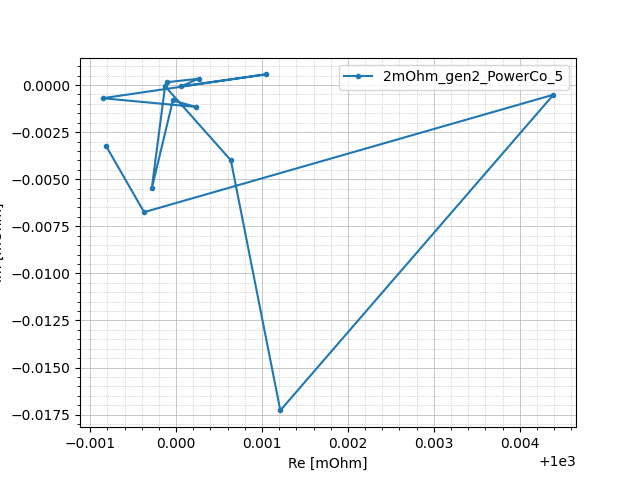

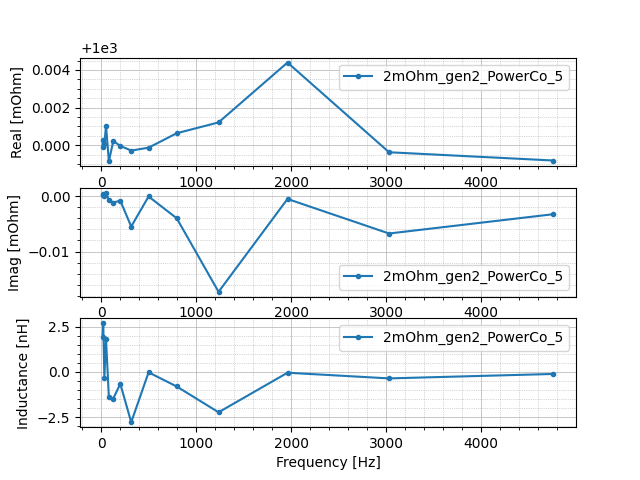

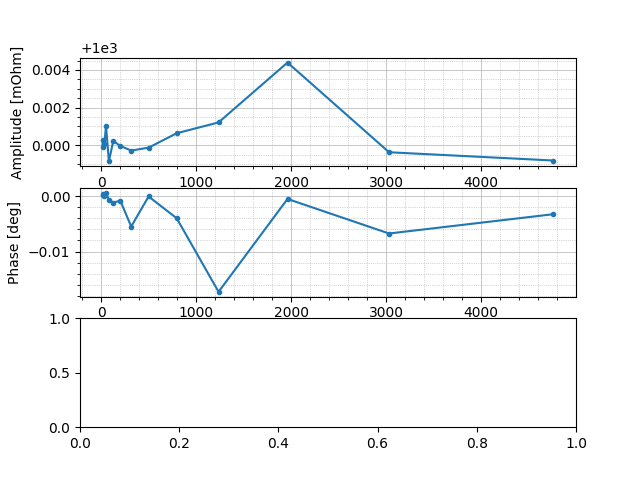

In [48]:
%matplotlib widget
impedance_dict = import_csv_folder(folder)

fig, ax = plt.subplots()
for impedance_name in impedance_dict:
    impedance_df = impedance_dict[impedance_name]
    plot_nyquist(ax, impedance_df, label=impedance_name, title='')

fig, ax = plt.subplots(3)
for impedance_name in impedance_dict:
    impedance_df = impedance_dict[impedance_name]
    plot_bode_re_imag(ax, impedance_df, label=impedance_name, title='')

fig, ax = plt.subplots(3)
for impedance_name in impedance_dict:
    impedance_df = impedance_dict[impedance_name]
    plot_bode(ax, impedance_df, label=impedance_name, title='')

### Corrected values

In [ ]:
%matplotlib widget
from copy import deepcopy

df_correct = pd.read_csv(correction_file)
impedance_dict = import_csv_folder(folder)

fig, ax = plt.subplots()
for impedance_name in impedance_dict:
    impedance_df = deepcopy(impedance_dict[impedance_name])

    impedance_df.Impedance_phase = 180/np.pi*np.unwrap(impedance_df.Impedance_phase*np.pi/180, period=np.pi*2, discont=np.pi/2)
    impedance_df.Impedance_phase = (impedance_df.Impedance_phase + 180) % 360 - 180

    impedance_df['Impedance_amplitude'] = impedance_df['Impedance_amplitude'] / (df_correct['Impedance_amplitude']/0.008)
    impedance_df['Impedance_phase']     = impedance_df['Impedance_phase'] - df_correct['Impedance_phase']

    impedance_df['Impedance_real'] = impedance_df.Impedance_amplitude * np.cos(impedance_df.Impedance_phase*np.pi/180)
    impedance_df['Impedance_imag'] = impedance_df.Impedance_amplitude * np.sin(impedance_df.Impedance_phase*np.pi/180)

    plot_nyquist(ax, impedance_df, label=impedance_name, title='')


# Applaying correction
#ref.data['Impedance_amplitude'] = ref.data['Impedance_amplitude'] / (df_correct['Impedance_amplitude']/0.008)
#ref.data['Impedance_phase']     = ref.data['Impedance_phase'] - df_correct['Impedance_phase']

In [ ]:
df_correct = pd.read_csv(correction_folder)

In [ ]:
df_correct

In [ ]:
impedance = impedance_dict['setup_zink_JLR_7']

impedance.Impedance_phase = 180/np.pi*np.unwrap(impedance.Impedance_phase*np.pi/180, period=np.pi*2, discont=np.pi/2)
impedance.Impedance_phase = (impedance.Impedance_phase + 180) % 360 - 180
    


In [ ]:
impedance['Impedance_amplitude'] = impedance['Impedance_amplitude'] / (df_correct['Impedance_amplitude']/0.008)
impedance['Impedance_phase']     = impedance['Impedance_phase'] - df_correct['Impedance_phase']

impedance['Impedance_real'] = impedance.Impedance_amplitude * np.cos(impedance.Impedance_phase*np.pi/180)
impedance['Impedance_imag'] = impedance.Impedance_amplitude * np.sin(impedance.Impedance_phase*np.pi/180)

In [ ]:
impedance_dict['setup_zink_JLR_7']

In [ ]:
impedance_dict['setup_zink_JLR_7'].to_csv('short_JLR_corr.csv')

In [ ]:
impedance_dict['1mOhm_zink_JLR_2']

In [ ]:
impedance_dict['1mOhm_zink_JLR_2'].to_csv('1mOhm_JLR_corr.csv')

# Testing

In [ ]:
import pyvisa
import numpy as np
import matplotlib.pyplot as plt

# Initialize VISA resource manager
rm = pyvisa.ResourceManager()

# Replace with your DAQ's VISA address
daq_resource = 'USB0::0x2A8D::0x5101::MY58021228::INSTR'
daq = rm.open_resource(daq_resource)
daq.timeout = 8000

# Query device ID to verify connection
device_id = daq.query("*IDN?")
print("Connected to:", device_id)

In [ ]:
daq.timeout = 8000

In [ ]:
sampl_rate = 50000

daq.write('ACQ3:VOLT 18V,DIFF,AC,TIME,1000,50000,(@101)')
daq.write('ACQ3:VOLT 18V,DIFF,AC,TIME,1000,50000,(@102)')

In [ ]:
daq.write('INIT3 (@101, 102)')

In [ ]:
print('CH1')
a1_str = daq.query('FETCh3? (@101)')
print('CH2')
a2_str = daq.query('FETCh3? (@102)')

In [ ]:
a1 = string_to_np_array(a1_str)
a1_i = np.arange(len(a1))/sampl_rate
a2 = string_to_np_array(a2_str)
a2_i = np.arange(len(a2))/sampl_rate



In [ ]:
params1 = fit_sine_wave(a1_i, a1)
params2 = fit_sine_wave(a2_i, a2)
print(params1)
print(params2)

In [ ]:
params1

In [ ]:
%matplotlib widget 

plt.figure(figsize=(10, 5))
plt.plot(a1_i, a1, label="a1")
#y_fit = params1[0] * np.sin(2 * np.pi * params1[2] * a1_i + params1[1])
#plt.plot(a1_i, y_fit, label="y_fit1")
plt.plot(a1_i, a2, label="a2")
#y_fit = params2[0] * np.sin(2 * np.pi * params2[2] * a2_i + params2[1])
#plt.plot(y_fit, label="y_fit2")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("DAQ Acquisition for a Single Frequency Point")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Sine function
def sine(t, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * t + phi) + C

# Generate sample data (Optional)
t = np.linspace(0, 10, 1000)  # Time vector
y_true = 3 * np.sin(2 * np.pi * 0.5 * t + np.pi/4) + 1  # True signal
y_noisy = y_true + 0.5 * np.random.normal(size=len(t))  # Noisy signal

# Initial guess [Amplitude, Frequency, Phase, Offset]
p0 = [np.std(y_noisy), 0.5, 0, np.mean(y_noisy)]

# Fit curve
params, _ = curve_fit(sine, t, y_noisy, p0=p0)

# Unpack fitted parameters
A, f, phi, C = params
print(f"Amplitude: {A:.3f}, Frequency: {f:.3f}, Phase: {phi:.3f}, Offset: {C:.3f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(t, y_noisy, label='Noisy Data', alpha=0.6)
plt.plot(t, sine(t, *params), 'r', label='Fitted Sine', linewidth=2)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sine Wave Fitting')
plt.grid(True)
plt.show()
